In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import os, time, random

import tensorflow as tf
from PIL import Image
from skimage import io

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#########################
# DL Libraries
#########################
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras import layers






In [3]:

dir_path='./chest_xray_dataset/'

train_path = dir_path+'train/'
valid_path = dir_path+'val/'
test_path = dir_path+'test/'

target_size = (300, 300)

input_shape = (300, 300, 1)
batch_size = 64

In [4]:
train_dir = tf.keras.preprocessing.image_dataset_from_directory(test_path, 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='binary')
# get classes length
print(train_dir.class_names)
print(train_dir)

# get siize clases

test = os.listdir(train_path)
test[0]

Found 303 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
<BatchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)>


'PNEUMONIA'

In [5]:
## method to create file systenm structure for the code to work
## run when some file systems breaks
def create_file_system(folder,labels):
    ## list items
    items = os.listdir(folder)
    if not os.path.exists(folder+labels[0]+"/"):
        os.mkdir(folder+labels[0]+"/")
    if not os.path.exists(folder+labels[1]+"/"):
        os.mkdir(folder+labels[1]+"/")
    for item in items:
        if contains(item, labels[0]):
            os.rename(folder+item, folder+labels[0]+"/"+item)
        elif contains(item, labels[1]):
            os.rename(folder+item, folder+labels[1]+"/"+item)
        else:
            print('error')
    
        

In [6]:
### check number of train, valid and test images 
labels = ['NORMAL', 'PNEUMONIA']
def contains(file_name, label):
    return file_name.__contains__(label) 

def check_ims_in_folder(labels):
    '''returns tuples of images in each folder'''
    if not os.path.exists(train_path+labels[0]+"/"):
        create_file_system(train_path, labels)
    train_ims_normal = os.listdir(train_path+labels[0]+'/')
    train_ims_pneumonia = os.listdir(train_path+labels[1]+'/')

    # no valid 
    if not os.path.exists(valid_path+labels[0]+"/"):
        create_file_system(valid_path, labels)
    valid_ims_normal = os.listdir(valid_path+labels[0]+'/')
    valid_ims_pneumonia = os.listdir(valid_path+labels[1]+'/')

    ## fixgins ifile system 
    if not os.path.exists(test_path+labels[0]+"/"):
        create_file_system(test_path, labels)
    test_ims_normal = os.listdir(test_path+labels[0]+'/')
    test_ims_pneumonia = os.listdir(test_path+labels[1]+'/')

    #test photos in other file system
    _test_ims_= os.listdir(test_path)
    # create two list for labels[0] and labels[1]
    # then loop over test_ims_ and check if it is in the list
    _test_ims_normal = list()
    _test_ims_pneumonia = list()
    for im in _test_ims_:
        if contains(im, labels[0]):
            _test_ims_normal.append(im)
        elif contains(im, labels[1]):
            _test_ims_pneumonia.append(im)
        else:
            print('error')
            
    
    return (train_ims_normal, train_ims_pneumonia), (valid_ims_normal, valid_ims_pneumonia), (test_ims_normal, test_ims_pneumonia)

[0.15 1.15 2.15 3.15 4.15 5.15]


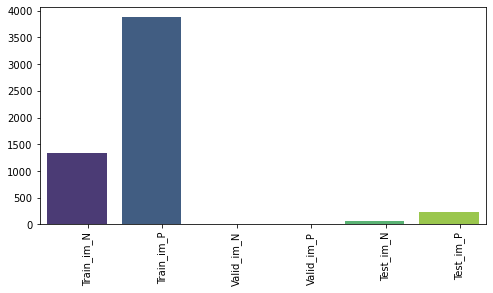

train_im_N:  1341
train_im_P:  3875
valid_im_N:  0
valid_im_P:  0
test_im_N:  69
test_im_P:  234


In [7]:
(train_im_n, train_im_p), (valid_im_n, valid_im_p), (test_im_n, test_im_p) = check_ims_in_folder(labels)


index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Valid_im_N', 'Valid_im_P', 'Test_im_N', 'Test_im_P']

fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(valid_im_n), len(valid_im_p), len(test_im_n), len(test_im_p)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('valid_im_N: ', len(valid_im_n))
print ('valid_im_P: ', len(valid_im_p))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))

# No Validation data 

In [8]:
tot_normal_train = len(train_im_n) + len(valid_im_n) 
tot_pneumonia_train = len(train_im_p) + len(valid_im_p)
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)


total normal xray images:  1341
total pneumonia xray images:  3875


In [9]:
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    if folder=='val':
        path = valid_path
        normal = valid_im_n
        pneumonia = valid_im_p
    elif folder=='train':
        path = train_path
        normal = train_im_n
        pneumonia = train_im_p
    else:
        path = test_path
        normal = test_im_n
        pneumonia = test_im_p
    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img) #if folder  is not 'test' else os.path.join(path, img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)  #if folder  is not 'test' else os.path.join(path, img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p

In [10]:
im_shape_valid_x_n, im_shape_valid_y_n, im_shape_valid_x_p, im_shape_valid_y_p = check_im_size('val', labels)
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p = check_im_size('test', labels)  

set() set()


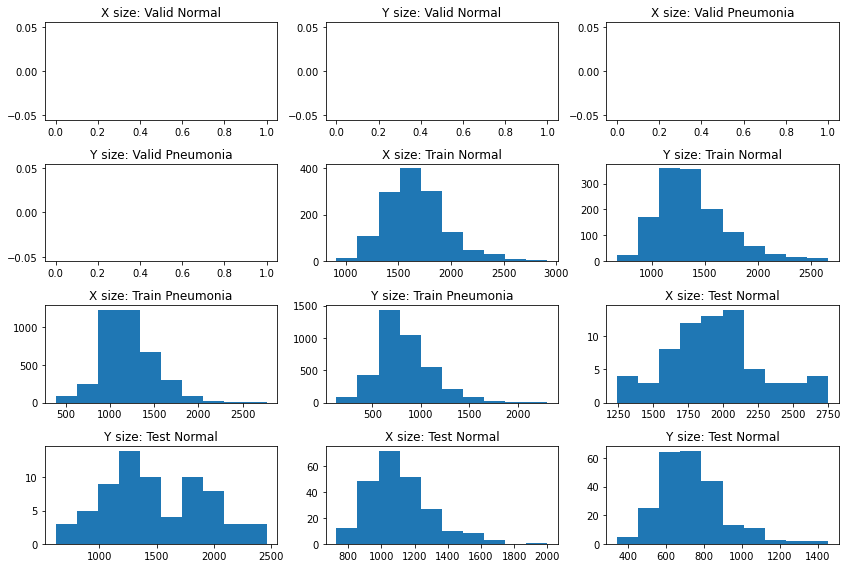

In [11]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(431)
plt.hist(im_shape_valid_x_n)
plt.title('X size: Valid Normal')
fig.add_subplot(432)
plt.hist(im_shape_valid_y_n)
plt.title('Y size: Valid Normal')
fig.add_subplot(433)
plt.hist(im_shape_valid_x_p)
plt.title('X size: Valid Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_valid_y_p)
plt.title('Y size: Valid Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(436)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(437)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(438)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(439)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Normal')
plt.tight_layout()
print (set(im_shape_valid_x_n), set(im_shape_valid_y_n))

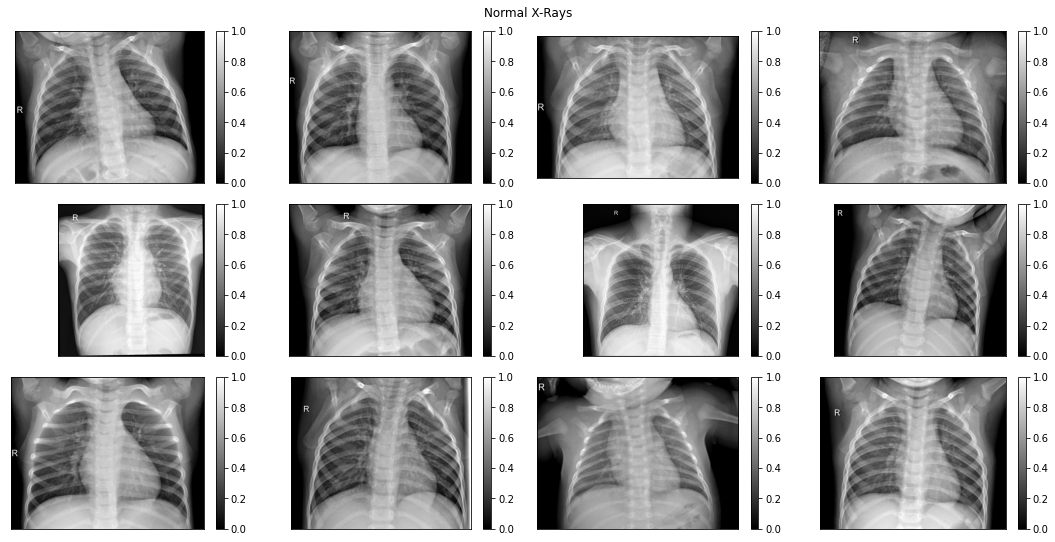

check shape of an example image:  (1286, 1570)


In [12]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(train_path +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

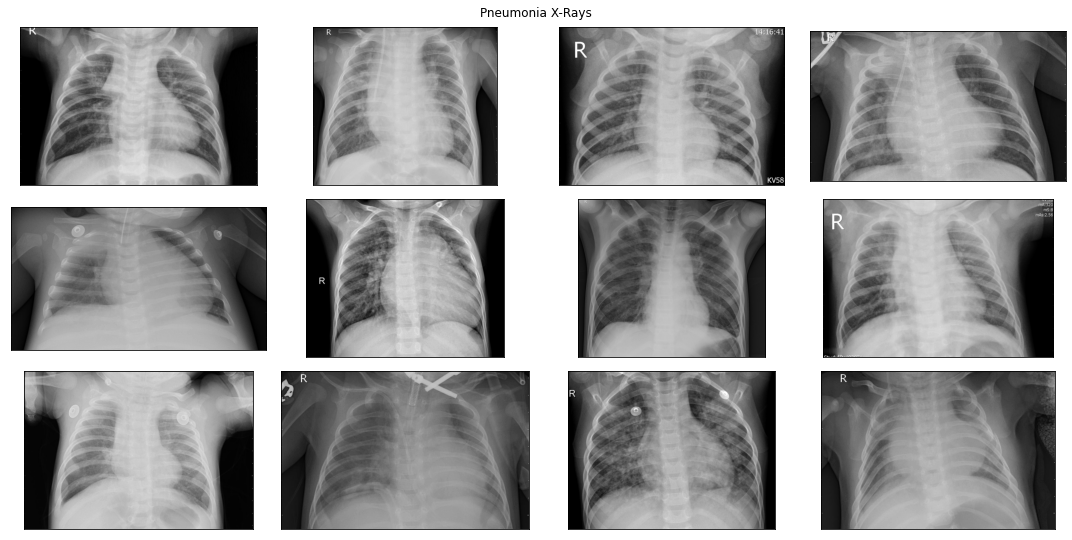

In [13]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_p_selected = random.sample(train_im_p, 12)
for i, img in enumerate(train_im_p_selected):
    sample = os.path.join(train_path +labels[1]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()
plt.show()

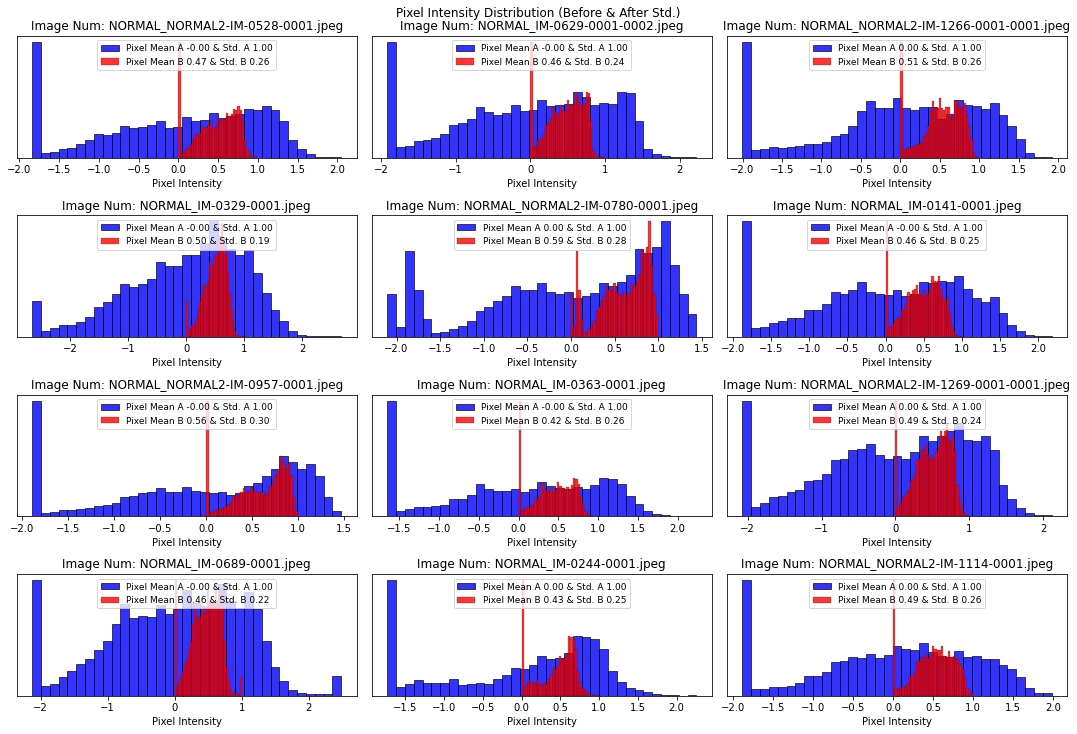

In [14]:
fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
    sample_one = os.path.join(train_path +labels[0]+'/', img)
    sample_img = Image.open(sample_one)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(), 
             label=f'Pixel Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(), 
             label=f'Pixel Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Image Num: %s'% (img))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Pixel Intensity Distribution (Before & After Std.)')
plt.tight_layout()
plt.show()

In [15]:
#### define a function that will be added as lambda layer later
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

In [16]:
target_size = (300, 300)

input_shape = (300, 300, 1)

batch_size = 64


print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory(train_path, 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='binary')



""" print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory(valid_path, 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='binary') """

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory(test_path, 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='binary')



Training Dataset.....
Found 5216 files belonging to 2 classes.
Test Datast...
Found 303 files belonging to 2 classes.


# Since there is no valid data, test using only the train data

In [17]:
new_train_ds = train_dir

print (new_train_ds, train_dir)

train_size = int(0.8 * 83) # 83 is the elements in dataset (train + valid)
val_size = int(0.2 * 83)
    
train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<BatchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)> <BatchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)>
66
16


2022-07-17 19:05:06.641882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-17 19:05:06.642418: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


(64, 300, 300, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 1)


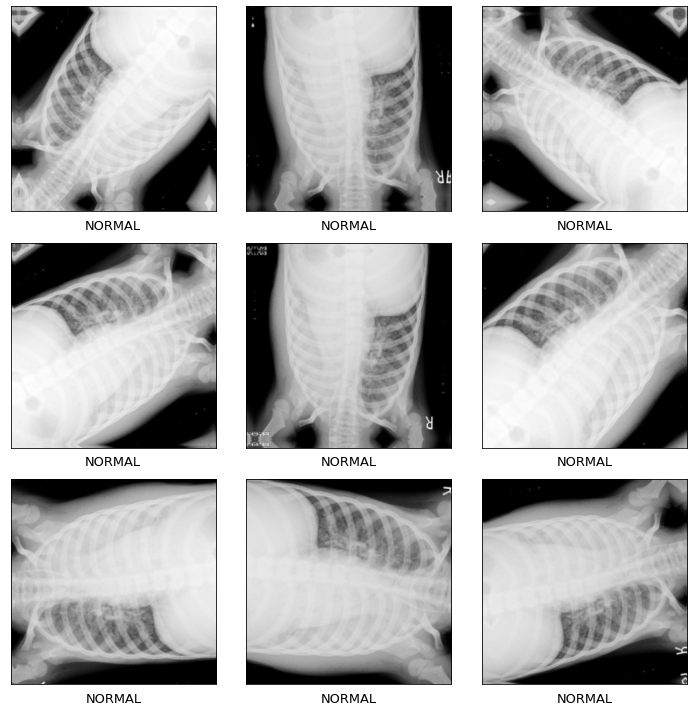

(64, 300, 300, 1) (300, 300, 1)


In [18]:
class_names = train_dir.class_names
rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])


### let's try something fancy 
from itertools import islice, count

train_iter_35im, train_iter_35label = next(islice(train_ds, 35, None)) # access the 35th element (just a random check) from the iterator



print (train_iter_35im.shape, type(train_iter_35im))
print (train_iter_35label.shape)

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_35label = train_iter_35label.numpy()


plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    aug_img = data_augmentation(train_iter_35im)
    plt.imshow(aug_img[0], cmap='gray')
    plt.xlabel(class_names[np.argmax(train_iter_35label)], fontsize=13)
plt.tight_layout()    
plt.show()

print (aug_img.shape, aug_img[0].shape)


In [19]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

In [20]:
#### check the numbers again
print (train_data_batches, valid_data_batches)

num_elements_train_data_batches = tf.data.experimental.cardinality(train_data_batches).numpy()
print (num_elements_train_data_batches)

<PrefetchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)> <PrefetchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)>
66


2022-07-17 19:05:21.265469: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


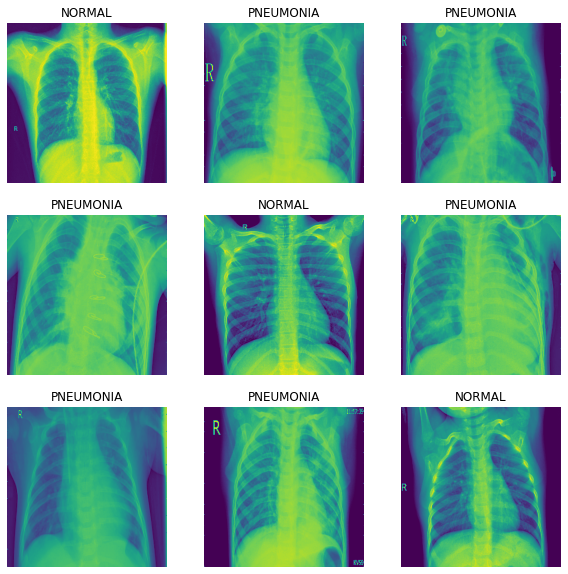

In [21]:
### check if the data batches work properly or not 

plt.figure(figsize=(10, 10))
for images, labels in train_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")  

BUILD MODEL SECUANTIAL 


In [22]:
## This cell was used to compile the baseline model
### Cosine Decay was tested

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)



# mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
#                            save_best_only=True, save_weights_only=True, monitor='val_loss')



## added after saving the best model  via val loss gives worse performance than the final step of the model 

mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')



##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


### added after 2nd training 

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

In [23]:
freq_neg = tot_normal_train/(tot_normal_train + tot_pneumonia_train)
freq_pos = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train)

pos_weights = np.array([freq_neg])
neg_weights = np.array([freq_pos])

print ('check positive weight: ', pos_weights, len(pos_weights))
print ('check negative weight: ', neg_weights)


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)): # we have only 1 class 
            # for each class, add average weighted loss for that class 
            loss += - (K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)) + 
                              (neg_weights[i] * (1-y_true[:, i]) * K.log(1-y_pred[:, i] + epsilon)) ) )
        return loss
    return weighted_loss

check positive weight:  [0.25709356] 1
check negative weight:  [0.74290644]


In [24]:
input_shape = (300, 300, 3)

inception_resnet_v2 = InceptionResNetV2(
    include_top=False,
    # dowladed to te model to work
    weights="./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=input_shape)

def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
    
    
    
    ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = inception_resnet_v2(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
#                   loss="binary_crossentropy", 
#                   metrics=METRICS)
# added weighted cross entropy loss for the loss instead of 
# "binary_crossentropy"

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss=get_weighted_loss(pos_weights, neg_weights), 
                 metrics=METRICS)



    
    return model

In [25]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 1)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 300, 300, 1)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 300, 300, 1)       0         
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 300, 300, 1)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 300, 300, 3)       30    

In [1]:
start_time = time.time()
history = model.fit(train_data_batches, 
                    epochs=100, 
                    validation_data=valid_data_batches,
                    callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()

NameError: name 'time' is not defined